## AdaBoost：自适应提升算法
通过改变训练样本权重来学习多个弱分类器并线性组合成强分类器的Boosting算法。

Boosting方法要解答的两个关键问题：一是在训练过程中如何改变训练样本的权重或者概率分布，二是如何将多个弱分类器组合成一个强分类器。  
AdaBoost的做法：一是提高前一轮被弱分类器分类错误的样本的权重，而降低分类正确的样本的权重；而是对多个弱分类器进行线性组合，提高分类效果好的弱分类器的权重，降低分类误差率高的弱分类器的权重。

### 一.手写提升算法

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

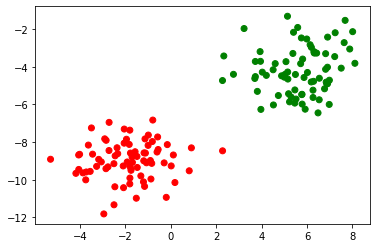

In [2]:
# 生成数据并查看
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs  # 导入sklearn模拟二分类数据生成模块
X, y =  make_blobs(n_samples=150, n_features=2, centers=2, cluster_std=1.2, random_state=40) # 生成模拟二分类数据集
# 将标签转换为1/-1
y_ = y.copy()
y_[y_==0] = -1
y_ = y_.astype(float)
X_train, X_test, y_train, y_test = train_test_split(X, y_, test_size=0.3, random_state=43) # 训练/测试数据集划分
colors = {0:'r', 1:'g'} # 设置颜色参数
plt.scatter(X[:,0], X[:,1], marker='o', c=pd.Series(y).map(colors)) # 绘制二分类数据集的散点图
plt.show();

In [3]:
### 定义决策树桩类
### 作为Adaboost弱分类器
class DecisionStump():
    def __init__(self):
        # 基于划分阈值决定样本分类为1还是-1
        self.label = 1
        # 特征索引
        self.feature_index = None
        # 特征划分阈值
        self.threshold = None
        # 指示分类准确率的值
        self.alpha = None

In [4]:
### 定义AdaBoost算法类
class Adaboost:
    # 弱分类器个数
    def __init__(self, n_estimators=5):
        self.n_estimators = n_estimators
        
    # Adaboost拟合算法
    def fit(self, X, y):
        m, n = X.shape
        # (1) 初始化权重分布为均匀分布 1/N
        w = np.full(m, (1/m))
        # 处初始化基分类器列表
        self.estimators = []
        # (2) for m in (1,2,...,M)
        for _ in range(self.n_estimators):
            # (2.a) 训练一个弱分类器：决策树桩
            estimator = DecisionStump()
            # 设定一个最小化误差
            min_error = float('inf')
            # 遍历数据集特征，根据最小分类误差率选择最优划分特征
            for i in range(n):
                # 获取特征值
                values = np.expand_dims(X[:, i], axis=1)
                # 特征取值去重
                unique_values = np.unique(values)
                # 尝试将每一个特征值作为分类阈值
                for threshold in unique_values:
                    p = 1
                    # 初始化所有预测值为1
                    pred = np.ones(np.shape(y))
                    # 小于分类阈值的预测值为-1
                    pred[X[:, i] < threshold] = -1
                    # 2.b 计算误差率
                    error = sum(w[y != pred])
                    
                    # 如果分类误差大于0.5，则进行正负预测翻转
                    # 例如 error = 0.6 => (1 - error) = 0.4
                    if error > 0.5:
                        error = 1 - error
                        p = -1

                    # 一旦获得最小误差则保存相关参数配置
                    if error < min_error:
                        estimator.label = p
                        estimator.threshold = threshold
                        estimator.feature_index = i
                        min_error = error
                        
            # 2.c 计算基分类器的权重
            estimator.alpha = 0.5 * np.log((1.0 - min_error) / (min_error + 1e-9))
            # 初始化所有预测值为1
            preds = np.ones(np.shape(y))
            # 获取所有小于阈值的负类索引
            negative_idx = (estimator.label * X[:, estimator.feature_index] < estimator.label * estimator.threshold)
            # 将负类设为 '-1'
            preds[negative_idx] = -1
            # 2.d 更新样本权重
            w *= np.exp(-estimator.alpha * y * preds)
            w /= np.sum(w)

            # 保存该弱分类器
            self.estimators.append(estimator)
    
    # 定义预测函数
    def predict(self, X):
        m = len(X)
        y_pred = np.zeros((m, 1))
        # 计算每个弱分类器的预测值
        for estimator in self.estimators:
            # 初始化所有预测值为1
            predictions = np.ones(np.shape(y_pred))
            # 获取所有小于阈值的负类索引
            negative_idx = (estimator.label * X[:, estimator.feature_index] < estimator.label * estimator.threshold)
            # 将负类设为 '-1'
            predictions[negative_idx] = -1
            # 2.e 对每个弱分类器的预测结果进行加权
            y_pred += estimator.alpha * predictions

        # 返回最终预测结果
        y_pred = np.sign(y_pred).flatten()
        return y_pred

In [5]:
##### 计算准确率
from sklearn.metrics import accuracy_score # 导入sklearn准确率计算函数
clf = Adaboost(n_estimators=5) # 创建Adaboost模型实例
clf.fit(X_train, y_train) # 模型拟合
y_pred = clf.predict(X_test) # 模型预测
accuracy = accuracy_score(y_test, y_pred) # 计算模型预测准确率
print("Accuracy of AdaBoost by numpy:", accuracy)

Accuracy of AdaBoost by numpy: 0.9777777777777777


### 二.使用sklearn

In [6]:
from sklearn.ensemble import AdaBoostClassifier # 导入sklearn adaboost分类器
clf_ = AdaBoostClassifier(n_estimators=5, random_state=0) # 创建Adaboost模型实例
clf_.fit(X_train, y_train) # 模型拟合
y_pred_ = clf_.predict(X_test) # 模型预测
accuracy = accuracy_score(y_test, y_pred_) # 计算模型预测准确率
print("Accuracy of AdaBoost by sklearn:", accuracy)

Accuracy of AdaBoost by sklearn: 0.9777777777777777
